In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Readme
Change dataset, crop_id, obj_id only

# 1. Crop images

In [59]:
# load sam
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model) #, crop_overlap_ratio = 750 / 1500) # , box_nms_thresh = 0.6 )

In [60]:
def move_to_device(segmentor_model, device="cuda"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)
move_to_device(custom_sam_model)

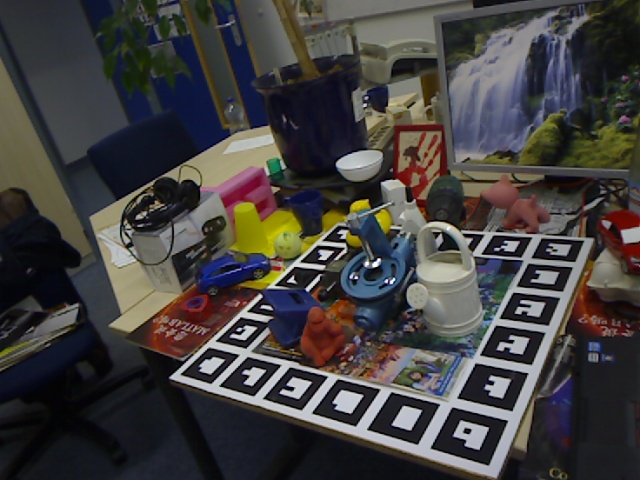

In [104]:
from PIL import Image
import torch
import numpy as np
from src.model.utils import Detections

dataset = "lmo"
rgb_path = "datasets/bop23_challenge/datasets/lmo/test/000002/rgb/000078.png" # f"datasets/bop23_challenge/datasets/{dataset}/test/000048/rgb/000001.png"
rgb = Image.open(rgb_path).convert("RGB")
sam_detections = custom_sam_model.generate_masks(np.array(rgb))
rgb

In [105]:
def extract_object_by_mask(image, mask, width: int = 512):
    mask = Image.fromarray(mask)
    masked_image = Image.composite(
        image, Image.new("RGB", image.size, (0, 0, 0)), mask)
    cropped_image = masked_image.crop(masked_image.getbbox())
    # new_height = width * cropped_image.height // cropped_image.width
    return cropped_image

masked_images = []
for mask in sam_detections["masks"].cpu():
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(rgb, binary_mask)
    masked_images.append(masked_image)

In [62]:
# # Visualize proposals
# import matplotlib.pyplot as plt
# from math import ceil
# def plot_images(images, rows, cols):
#     fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
#     for i, ax in enumerate(axes.flat):
#         if i >= len(images):
#             break
#         ax.imshow(images[i])
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Define the number of rows and columns in the grid
# rows = ceil(len(masked_images) / 6)
# cols = 6
# # Plot the masked_images array in a grid
# plot_images(masked_images, rows, cols) 

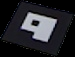

In [106]:
import os

# Choose crop 4 it is in object id 12
crop_idx = 1 # 125, 102 for background; 131 for foreground
obj_id = 1
crop1 = {
    "crop" : masked_images[crop_idx], # it is saved as Image so crop1["crop"] to visualize it
    "masks" : sam_detections["masks"][crop_idx],
    "boxes" : sam_detections["boxes"][crop_idx]
}

# Save image
if not os.path.exists(f"foundpose_analysis/{dataset}"):
    os.makedirs(f"foundpose_analysis/{dataset}")
crop1["crop"].save(f"foundpose_analysis/{dataset}/crop1.png")
crop1["crop"]

# 2. Templates

## 2.1 Create templates of object

In [65]:
# load config file
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

# Initialize Hydra and compose the configuration
# initialize(config_path="configs")
cfg = compose(config_name="run_inference")
OmegaConf.set_struct(cfg, False)

In [66]:
import os
import glob

default_ref_dataloader_config = cfg.data.reference_dataloader
ref_dataloader_config = default_ref_dataloader_config.copy()
ref_dataloader_config._target_ = "src.dataloader.bop_pbr.BOPTemplatePBR"
ref_dataloader_config.root_dir = f"datasets/bop23_challenge/datasets/{dataset}"
ref_dataloader_config.template_dir = " "

level_template = 1 # Level 0 :42 templates, level 1, 162 templates
ref_dataloader_config.level_templates = level_template 
ref_dataloader_config.split = "train_pbr" # train_pbr

ply_files = glob.glob(f"datasets/bop23_challenge/datasets/{dataset}/models/models/*.ply")
obj_ids = sorted([int(os.path.basename(obj_id)[8:10]) for obj_id in ply_files])
ref_dataloader_config.obj_ids = obj_ids

out_folder = f"foundpose_analysis/{dataset}/templates"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
ref_dataloader_config.out_dir = out_folder
ref_dataloader_config.templates_output_folder = f"{out_folder}/level_template_{level_template}"

In [67]:
import os
os.environ['HYDRA_FULL_ERROR'] = '1'

In [68]:
# # Error : must delete all metadata.csv 
# # If using test it can happen that the object id doesnt appear in the test folder- so can get empty list - just use try except la ok
# from hydra.utils import instantiate
# ref_dataset = instantiate(ref_dataloader_config) # src.dataloader.bop.BOPTemplatePBR
# ref_dataset.load_processed_metaData(reset_metaData=True)

In [69]:
# from torchvision.utils import save_image
# import pandas as pd
# import pickle

# templates = pd.read_csv(f"{out_folder}/{ref_dataloader_config.split}_processed_metaData.csv")

# # Save templates as images
# for ob_id in range(len(obj_ids)): 
#     obj_id_path = os.path.join(f"{out_folder}/{ref_dataloader_config.split}_images_templates", f'obj_{(ob_id+1):06d}') # The transformed templates - check line 244, 245 in bop_pbr.py
#     original_obj_id_path = os.path.join(f"{out_folder}/{ref_dataloader_config.split}_images_templates", f'obj_{(ob_id+1):06d}_original')
    
#     if not os.path.exists(obj_id_path):
#         os.makedirs(obj_id_path)
#     if not os.path.exists(original_obj_id_path):
#         os.makedirs(original_obj_id_path)

#     try:  
#         for i, img in enumerate(ref_dataset[ob_id]["templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#             save_image(img, os.path.join(obj_id_path, f'{i:06d}.png'))
#         for i, img in enumerate(ref_dataset[ob_id]["original_templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#             save_image(img, os.path.join(original_obj_id_path, f'{i:06d}.png'))
        
#         poses = []
#         for i, pose in enumerate(ref_dataset[ob_id]["poses"]):
#             poses.append(pose)
#         with open(f'{original_obj_id_path}/poses.pkl', 'wb') as file:
#             pickle.dump(poses, file)

#     except Exception as e:
#         print(f"An error occurred: {e}")

## 2.2. Templates features extraction

In [70]:
import glob
import os

obj_id_2 = 2
syn_data_type = "train_pbr" # test

# Load original templates when before putting through dinov2 we also apply transformation.
syn_template_path_1 = f"{out_folder}/{syn_data_type}/obj_{obj_id:06d}_original" 
syn_template_path_2 = f"{out_folder}/{syn_data_type}/obj_{obj_id_2:06d}_original" 
syn_template_files_1 = sorted(glob.glob(os.path.join(syn_template_path_1, "*.png")), key=os.path.getmtime)
syn_template_files_2 = sorted(glob.glob(os.path.join(syn_template_path_2, "*.png")), key=os.path.getmtime)
syn_template_files = syn_template_files_1 # + syn_template_files_2
syn_num_templates = len(syn_template_files)
syn_num_templates

162

In [71]:
# import glob
# import os

# obj_id_2 = 2

# # Load original templates when before putting through dinov2 we also apply transformation.
# pyrender_template_path_1 = f"datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_{obj_id:06d}" 
# pyrender_template_path_2 = f"datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_{obj_id_2:06d}" 
# pyrender_template_files_1 = sorted(glob.glob(os.path.join(pyrender_template_path_1, "*.png")), key=os.path.getmtime)
# pyrender_template_files_2 = sorted(glob.glob(os.path.join(pyrender_template_path_2, "*.png")), key=os.path.getmtime)
# pyrender_template_files = pyrender_template_files_1 # + pyrender_template_files_2
# pyrender_num_templates = len(pyrender_template_files)
# pyrender_num_templates

In [72]:
from PIL import Image
import numpy as np
# [50:450, 150:500, :3] only for pyrender template not for BlenderProc templates
# real_templates = [np.array(Image.open(template_file).convert("RGB"))[:,:,:3] for template_file in real_template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity
syn_templates = [np.array(Image.open(template_file).convert("RGB"))[:,:,:3] for template_file in syn_template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity
# pyrender_templates = [np.array(Image.open(template_file).convert("RGB"))[50:450, 150:500, :3] for template_file in pyrender_template_files]

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitl14.patch_size = 14
if torch.cuda.is_available():
    dinov2_vitl14 = torch.nn.DataParallel(dinov2_vitl14).to(device)  # Use DataParallel for multiple GPUs

Using cache found in /home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main


In [74]:
from src.model.custom_cnos import cnos_templates_feature_extraction

# real_ref_features = cnos_templates_feature_extraction(
#     templates = real_templates, num_templates = real_num_templates, dino_model = dinov2_vitl14, device = device
#     )
syn_ref_features = cnos_templates_feature_extraction(
    templates = syn_templates, num_templates = syn_num_templates, dino_model = dinov2_vitl14, device = device
    )
# pyrender_ref_features = cnos_templates_feature_extraction(
#     templates = pyrender_templates, num_templates = pyrender_num_templates, dino_model = dinov2_vitl14, device = device
#     )

/home/cuong.van-dam/CuongVanDam/do_an_tot_nghiep/cnos/src/model/constrastive_learning.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scaled_image = F.interpolate(torch.tensor(image).unsqueeze(0), scale_factor=scale_factor.item())[0] # unsqueeze at  0 - B,C, H, W


# 3. Combining Foundpose and Cnos

In [117]:
from src.model.custom_cnos import cnos_crop_feature_extraction
from src.model.custom_cnos import calculate_similarity as cnos_calculate_similarity

cnos_rounded_avg_score = list()
cnos_rounded_scores = list()
# normal crop
for i in range(len(masked_images)):
    crop_rgb = np.array(masked_images[i]) # (124, 157, 3)
    normal_features = cnos_crop_feature_extraction(crop_rgb, dinov2_vitl14, device)

    rounded_avg_score, rounded_scores = cnos_calculate_similarity(crop_rgb, normal_features, syn_ref_features, syn_templates)
    cnos_rounded_avg_score.append(rounded_avg_score)
    cnos_rounded_scores.append(rounded_scores)

/home/cuong.van-dam/CuongVanDam/do_an_tot_nghiep/cnos/src/model/constrastive_learning.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scaled_image = F.interpolate(torch.tensor(image).unsqueeze(0), scale_factor=scale_factor.item())[0] # unsqueeze at  0 - B,C, H, W


In [118]:
from sklearn.decomposition import PCA
from src.model.foundpose import calculate_similarity, crop_feature_extraction_3
from src.model.foundpose import (
    crop_feature_extraction, 
    kmeans_clustering, 
    calculate_templates_labels, 
    calculate_templates_vector,
    calculate_crop_vector,
    calculate_similarity,
    templates_feature_extraction,
    templates_feature_extraction_3
)

def bow_retrieval(crop_rgb, templates, valid_patch_features, num_valid_patches, dino_model = dinov2_vitl14, device = device):
    crop_num_valid_patches, valid_crop_feature_patches = crop_feature_extraction_3(crop_rgb = crop_rgb, dino_model = dinov2_vitl14, device = device)
    all_valid_patch_features = torch.cat((valid_crop_feature_patches.to('cpu'), valid_patch_features), dim=0)
    # PCA
    pca = PCA(n_components=256, random_state=5)
    pca_crop_patches_descriptors = pca.fit_transform(np.array(all_valid_patch_features.cpu()))
    
    pca_crop = pca_crop_patches_descriptors[:valid_crop_feature_patches.shape[0]]
    pca_templates = pca_crop_patches_descriptors[valid_crop_feature_patches.shape[0]:]

    kmeans = kmeans_clustering(pca_templates, ncentroids = 2048, niter = 20, verbose = True)
    templates_labels = calculate_templates_labels(num_valid_patches, kmeans, pca_templates)
    templates_vector = calculate_templates_vector(templates_labels = templates_labels, num_clusters = 2048)

    # Assign labels to the data points
    crop_labels = kmeans.index.search(pca_crop, 1)[1].reshape(-1)
    
    crop_vector = calculate_crop_vector(crop_labels = crop_labels, templates_labels = templates_labels, num_clusters = 2048)
    concat_templates_vector = torch.cat([torch.tensor(vector).view(1,-1) for vector in templates_vector]) # Goal torch.Size([642, 2048])

    # Compare crop to templates
    rounded_avg_score, rounded_scores = calculate_similarity(crop_rgb, crop_vector, concat_templates_vector, templates, synthetic=True)
    return rounded_avg_score, rounded_scores


In [119]:
import glob
import os

obj_id_2 = 2
syn_data_type = "train_pbr" # test
out_folder = f"foundpose_analysis/{dataset}/templates"

# Load original templates when before putting through dinov2 we also apply transformation.
syn_template_path_1 = f"{out_folder}/{syn_data_type}/obj_{obj_id:06d}_original" 
syn_template_path_2 = f"{out_folder}/{syn_data_type}/obj_{obj_id_2:06d}_original" 
syn_template_files_1 = sorted(glob.glob(os.path.join(syn_template_path_1, "*.png")), key=os.path.getmtime)
syn_template_files_2 = sorted(glob.glob(os.path.join(syn_template_path_2, "*.png")), key=os.path.getmtime)
syn_template_files = syn_template_files_1 # + syn_template_files_2
syn_num_templates = len(syn_template_files)
syn_num_templates

syn_templates = [np.array(Image.open(template_file).convert("RGB"))[:,:,:3] for template_file in syn_template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity

def _create_mask(image, threshold=10):
    return (np.sum(np.array(image), axis=2) > threshold).astype(np.uint8)

mask_syn_templates = [_create_mask(syn_temp) for syn_temp in syn_templates] # This image has 4 channels- the last one is not crucial - maybe about opacity


syn_num_valid_patches, syn_valid_patch_features = templates_feature_extraction_3(
    templates = syn_templates, 
    template_masks = mask_syn_templates, 
    num_templates = syn_num_templates, 
    dino_model = dinov2_vitl14, 
    device = device
)

In [78]:
foundpose_average_scores = list()
foundpose_top_5_scores = list()
for i in range(len(masked_images)):
# for i in range(0,2):
    crop_rgb = np.array( masked_images[i]) # (124, 157, 3)
    # bow_retrieval(crop_rgb, real_templates, real_valid_patch_features, real_num_valid_patches)
    rounded_avg_score, rounded_scores = bow_retrieval(crop_rgb, syn_templates, syn_valid_patch_features, syn_num_valid_patches)
    foundpose_average_scores.append(rounded_avg_score)
    foundpose_top_5_scores.append(rounded_scores)
    # bow_retrieval(crop_rgb, pyrender_templates, pyrender_valid_patch_features, pyrender_num_valid_patches)

Clustering 81184 points in 256D to 2048 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.01 s
  Iteration 19 (0.31 s, search 0.21 s): objective=7.30361e+07 imbalance=1.159 nsplit=0       
Clustering 81184 points in 256D to 2048 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.01 s
  Iteration 19 (0.27 s, search 0.21 s): objective=7.31624e+07 imbalance=1.160 nsplit=0       
Clustering 81184 points in 256D to 2048 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.01 s
  Iteration 19 (0.27 s, search 0.22 s): objective=7.30244e+07 imbalance=1.157 nsplit=0       
Clustering 81184 points in 256D to 2048 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.01 s
  Iteration 19 (0.28 s, search 0.22 s): objective=7.31615e+07 imbalance=1.158 nsplit=0       
Clustering 81184 points in 256D to 2048 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.01 s
  Iteration 19 (0.30 s, search 0.21 s): objective=7.30937e+07 imbalance=1.156 nsplit=0       
Clustering

In [120]:
score_dict = {
    "cnos_avg_scores" : cnos_rounded_avg_score,
    "cnos_top_5_scores" : cnos_rounded_scores,
    "foundpose_avg_scores" : foundpose_average_scores,
    "foundpose_top_5_scores" : foundpose_top_5_scores
}
# cnos_rounded_avg_score, cnos_rounded_scores
# foundpose_average_scores, foundpose_top_5_scores

In [121]:
import pickle

with open('cnos_foundpose_analysis/lmo/score_dict_2_78.pkl', 'wb') as file:
    pickle.dump(score_dict, file)


In [122]:
import pickle

with open('cnos_foundpose_analysis/icbin/score_dicts/score_dict_1_7.pkl', 'rb') as file:
    score_dict = pickle.load(file)

cnos_rounded_avg_score = score_dict["cnos_avg_scores"]
cnos_rounded_scores = score_dict["cnos_top_5_scores"]
foundpose_average_scores = score_dict["foundpose_avg_scores"]
foundpose_top_5_scores = score_dict["foundpose_top_5_scores"]


In [125]:
combined_avg_scores = [(cnos_rounded_avg_score[i] + foundpose_average_scores[i])/2 for i in range(len(foundpose_average_scores))]

selected_proposals_indices = [i for i, a_s in enumerate(combined_avg_scores) if a_s >0.35]
selected_proposals_scores = [a_s for i, a_s in enumerate(combined_avg_scores) if a_s >0.35]
cnos_selected_proposals_indices = [i for i, a_s in enumerate(cnos_rounded_avg_score) if a_s >0.5]
cnos_selected_proposals_scores = [a_s for i, a_s in enumerate(cnos_rounded_avg_score) if a_s >0.5]
foundpose_selected_proposals_indices = [i for i, a_s in enumerate(foundpose_average_scores) if a_s >0.2]
foundpose_selected_proposals_scores = [a_s for i, a_s in enumerate(foundpose_average_scores) if a_s >0.2]

In [88]:
len(foundpose_selected_proposals_indices)

26

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Number of images to display at a time
# images_per_page = 25

# # Define the number of rows and columns for the grid
# rows = 5
# cols = 5

# # Iterate over the indices in idx_selected_proposals in steps of images_per_page
# for i in range(0, len(selected_proposals_indices), images_per_page):
#     # Create a new figure for each set of images
#     plt.figure(figsize=(15, 15))

#     for j in range(images_per_page):
#         # Calculate the current index in idx_selected_proposals
#         current_index = i + j

#         # Check if the current index is within the bounds of idx_selected_proposals
#         if current_index >= len(selected_proposals_indices):
#             break

#         # Get the image index from idx_selected_proposals
#         image_index = selected_proposals_indices[current_index]
#         image_prob = selected_proposals_scores[current_index]

#         # Add a subplot for the current image
#         plt.subplot(rows, cols, j + 1)
#         plt.imshow(np.array(masked_images[image_index]))
#         plt.title(f"Index {image_index}: {image_prob}")
#         plt.axis('off')

#     # Display the figure containing the images
#     plt.show()


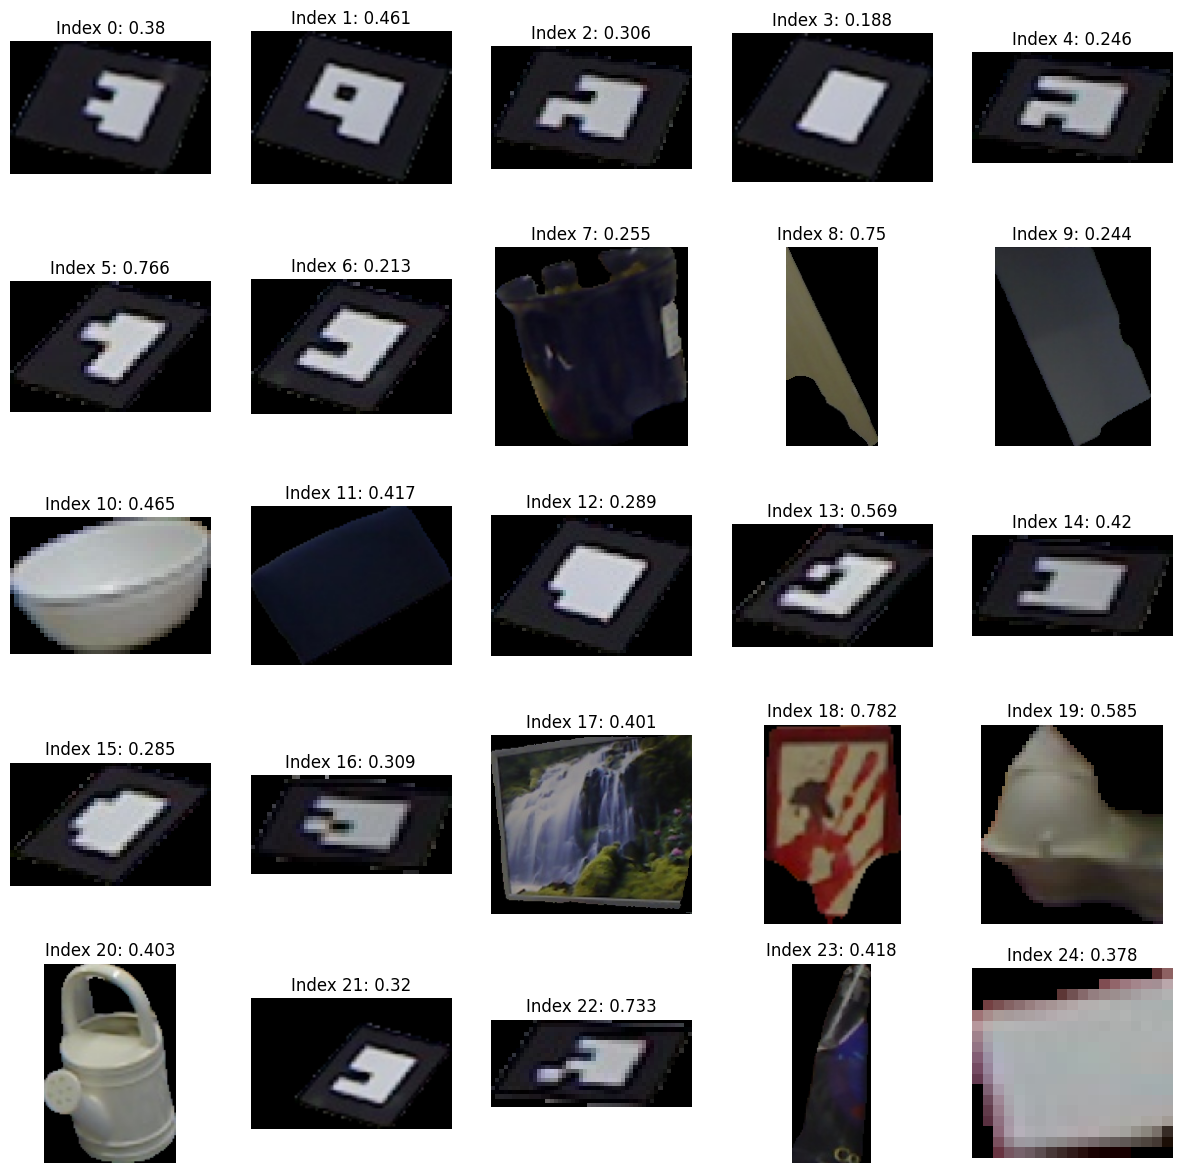

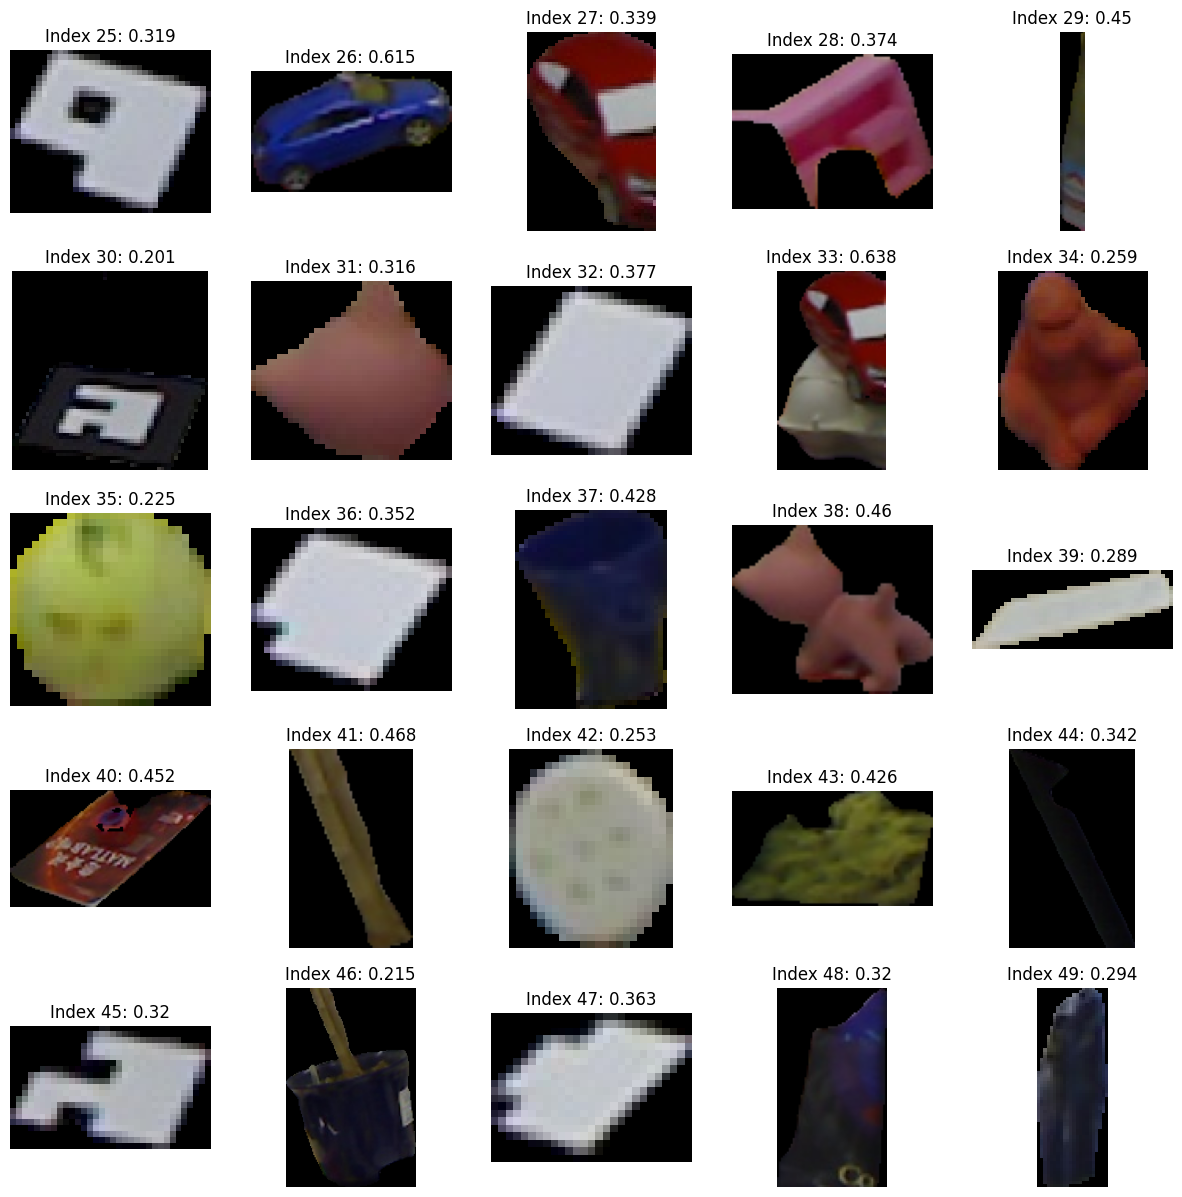

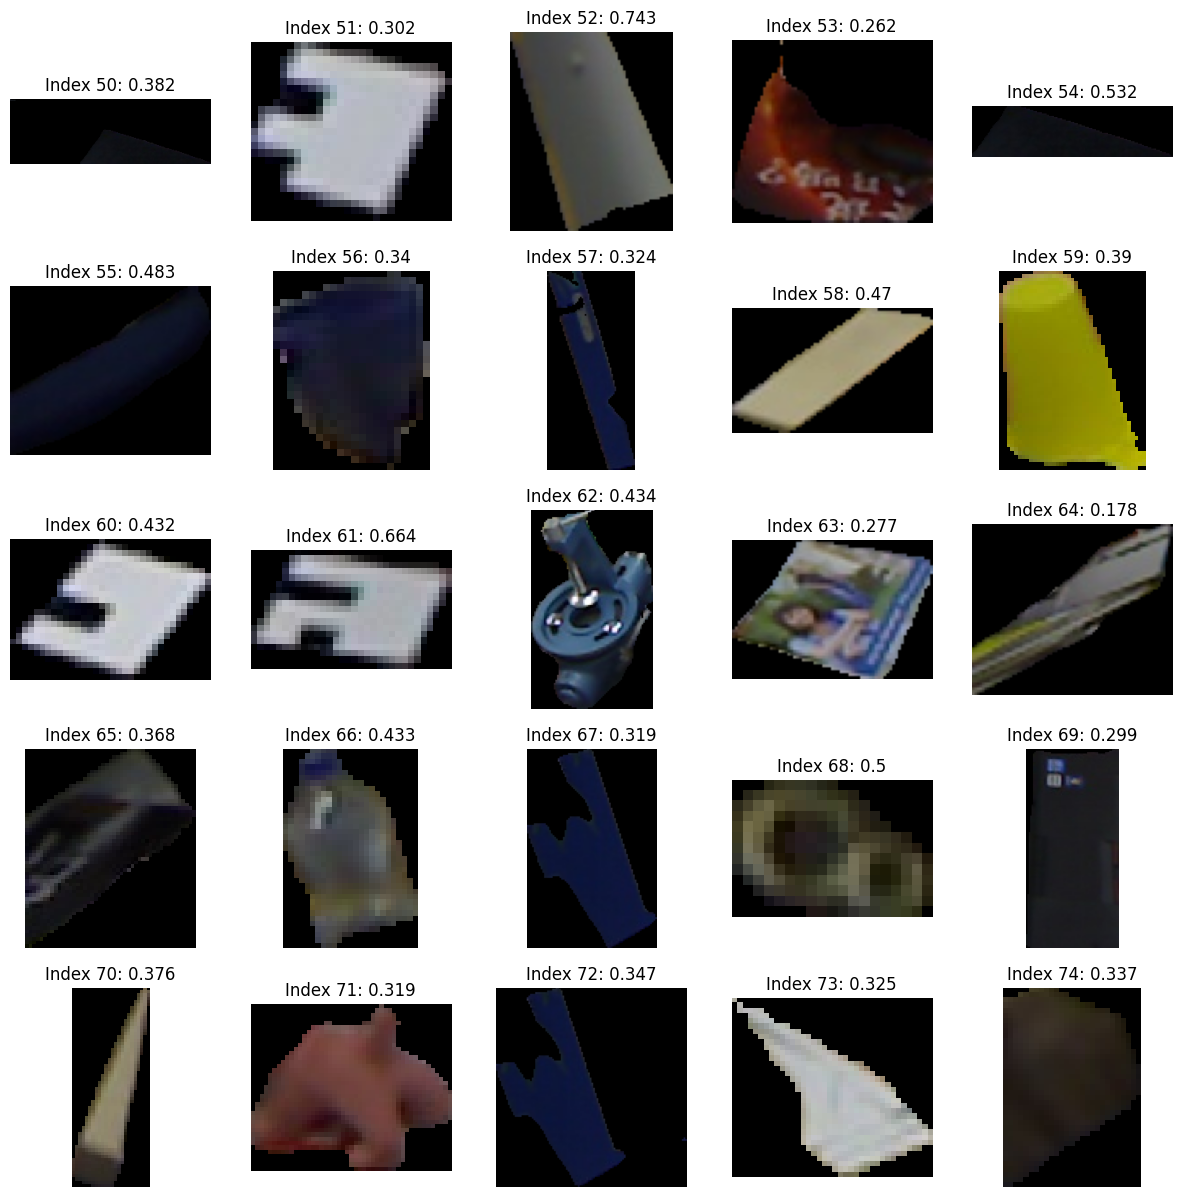

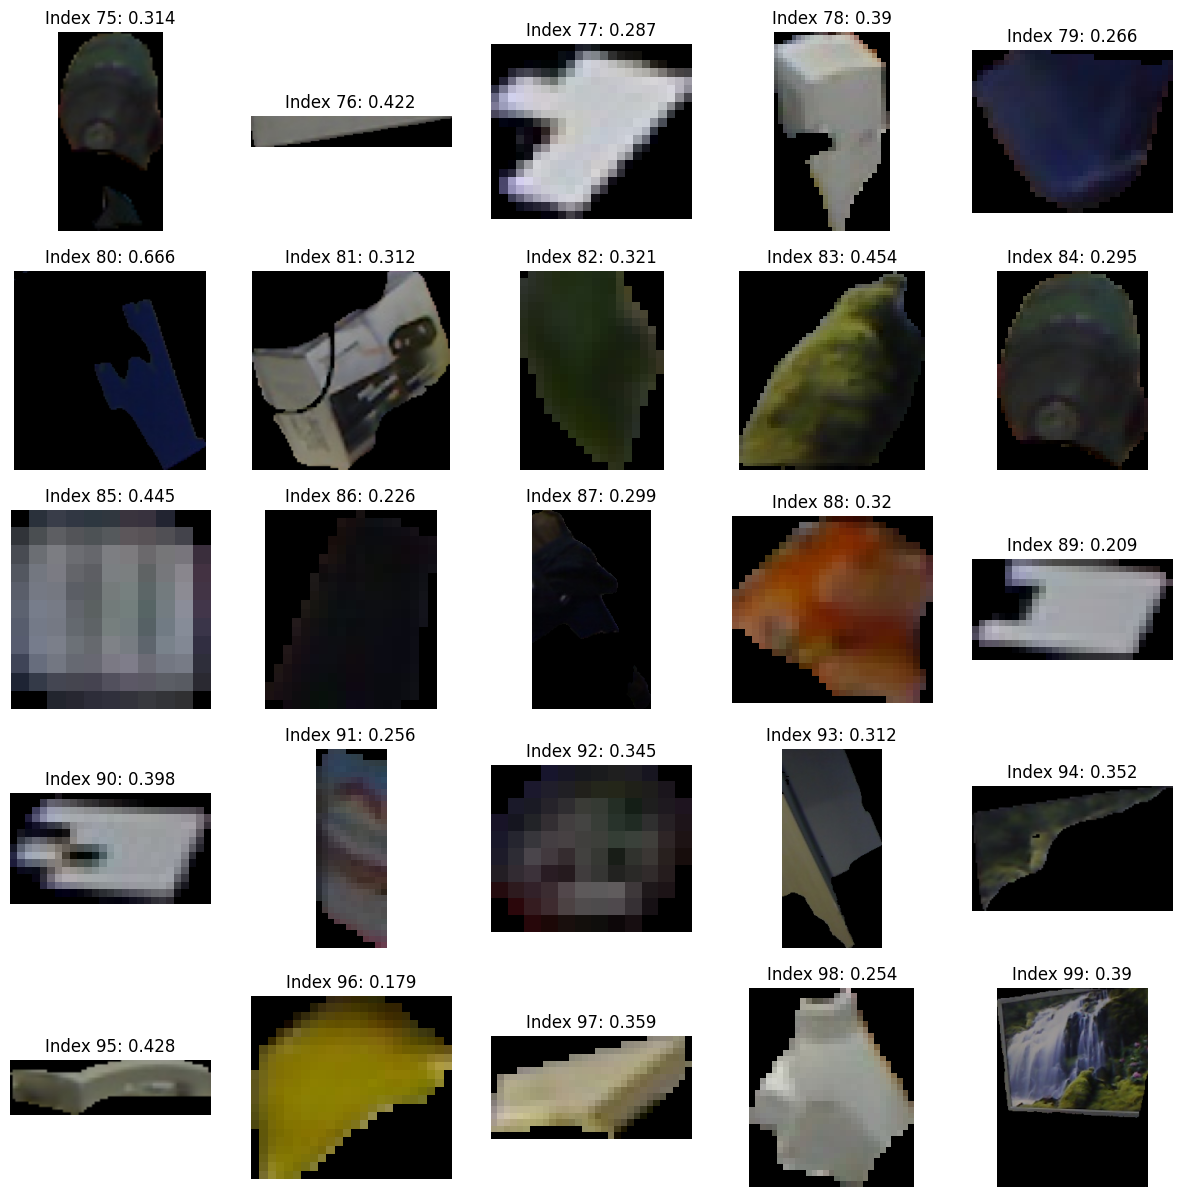

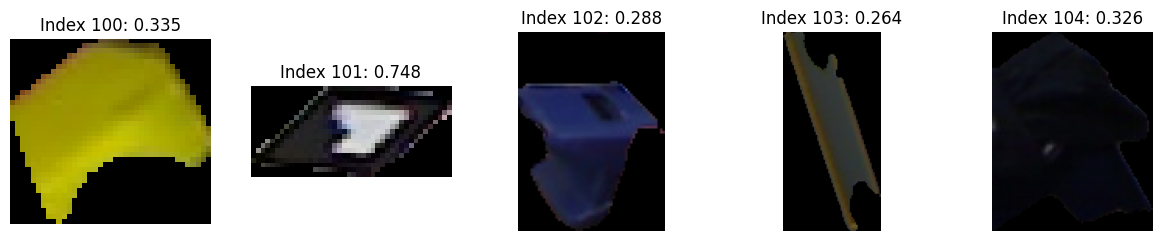

: 

In [126]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to display at a time
images_per_page = 25

# Define the number of rows and columns for the grid
rows = 5
cols = 5

# Iterate over the indices in idx_selected_proposals in steps of images_per_page
for i in range(0, len(cnos_rounded_avg_score), images_per_page):
    # Create a new figure for each set of images
    plt.figure(figsize=(15, 15))

    for j in range(images_per_page):
        # Calculate the current index in idx_selected_proposals
        current_index = i + j

        # Check if the current index is within the bounds of idx_selected_proposals
        if current_index >= len(cnos_rounded_avg_score):
            break

        # Get the image index from idx_selected_proposals
        image_index = current_index
        image_prob = cnos_rounded_avg_score[current_index]

        # Add a subplot for the current image
        plt.subplot(rows, cols, j + 1)
        plt.imshow(np.array(masked_images[image_index]))
        plt.title(f"Index {image_index}: {image_prob}")
        plt.axis('off')

    # Display the figure containing the images
    plt.show()


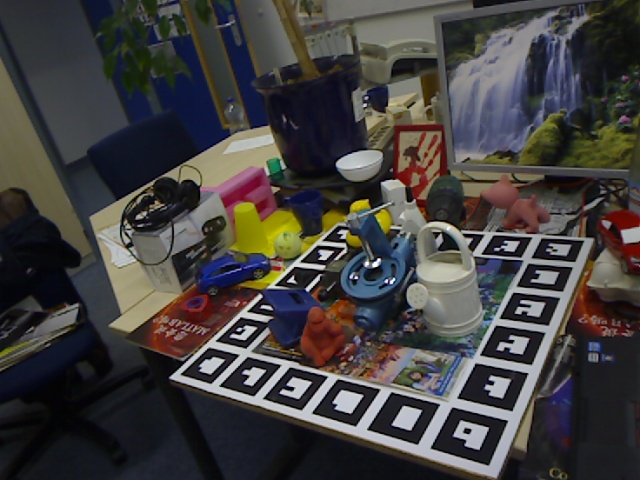

In [114]:
rgb

File contrastive_learning/outputs/test.json does not exist.
File contrastive_learning/outputs/test.npz has been deleted.


100%|██████████| 26/26 [00:09<00:00,  2.75it/s]


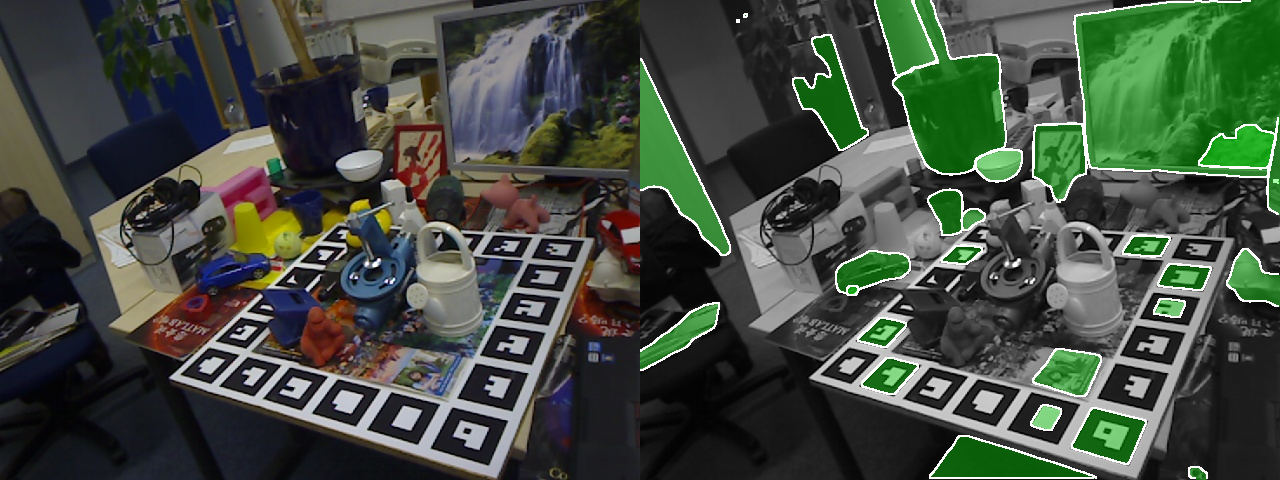

In [115]:
from src.model.custom_cnos import custom_detections, custom_visualize, custom_detections_2, custom_visualize_2

scene_id = 1
image_id = 1
dataset_name = "lmo"
real_data_type = "test"
# rgb_path = 'datasets/bop23_challenge/datasets/icbin/train_pbr/000001/rgb/000000.jpg'
file_path = f"contrastive_learning/outputs/{real_data_type}"
custom_detections_2(sam_detections, foundpose_selected_proposals_indices, file_path, scene_id=1, frame_id=1)

results = np.load(file_path+".npz")
dets = []
for i in range(results["segmentation"].shape[0]):
    det = {
    "scene_id": results["scene_id"],
    "image_id": results["image_id"],
    "category_id": results["category_id"][i],
    "bbox": results["bbox"][i],
    "segmentation": results["segmentation"][i],
    }
    dets.append(det)

final_result = custom_visualize_2(dataset_name, rgb_path, dets)
final_result
# see the results lb- lots of white crops are confused and clssified as objects

In [116]:
rgb_path

'datasets/bop23_challenge/datasets/lmo/test/000002/rgb/000078.png'